### Notebook to compute patch-mean value on CUMULO data

In [2]:
%reload_ext autoreload
%autoreload 2
import os
import gc
import re
import sys
import glob
import pickle
import numpy as np
import scipy as sc
import pandas as pd
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pyhdf.SD import SD, SDC
from scipy.stats import mode
from tensorflow.python.keras.models import Model
from tensorflow.data.experimental import parallel_interleave
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# Image Pillow
from PIL import Image #, ImageEnhance

In [3]:
def data_extractor_fn(filelist,prefetch=1,read_threads=1, distribute=(1, 0), shape_size=2):
    def parser(ser):
        """
        Decode & Pass datast in tf.record
        *Cuation*
        floating point: tfrecord data ==> tf.float64
        """

        features = {
            "shape": tf.FixedLenFeature([shape_size], tf.int64),
            "patch": tf.FixedLenFeature([], tf.string),
            "filename": tf.FixedLenFeature([], tf.string),
            "coordinate": tf.FixedLenFeature([2], tf.int64),
        }        
        decoded = tf.parse_single_example(ser, features)
        patch = tf.reshape(
            tf.decode_raw(decoded["patch"], tf.float64), decoded["shape"]
        )
        coord=decoded["coordinate"]
        return patch, coord
    
    dataset = (
        tf.data.Dataset.list_files(filelist, shuffle=False)
            .shard(*distribute)
            .apply(
            parallel_interleave(
                lambda f: tf.data.TFRecordDataset(f).map(parser),
                cycle_length=read_threads,
                sloppy=True,
            )
        )
    )
    iterator = dataset.make_one_shot_iterator()

    next_element = iterator.get_next()
    patch_list = []
    coord_list = []
    with tf.Session() as sess:
        try:
            while True:
                patch, coord = sess.run(next_element)
                patch_list.append(patch)
                coord_list.append(coord)
        except tf.errors.OutOfRangeError:
            print("OutOfRage --> finish process")
            pass
    return patch_list, coord_list

In [4]:
def pkl_loader(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

### Read Mod06 pkl and TF data

In [5]:
pkl_mod06dir = '/home/tkurihana/Research/data/MYD06/20080101/pkl'

In [6]:
tf_datadir = "/home/tkurihana/Research/data3/clouds_MYD_laads_multiprocessed_20080101_timestamp_stride" # stride 64

In [7]:
fileorder = np.load("./sort_file_names_20080101.npy") # order of file

#### load tf coords

In [ ]:
coords_list = []
for idx, i in enumerate(fileorder):
    fbasename = os.path.basename(i).rstrip('.tfrecord')
    ifile = os.path.join(tf_datadir, f"{fbasename}.tfrecord")
    _patches, tmp_coord_list = data_extractor_fn([ifile], shape_size=3)
    coords_list.append(tmp_coord_list)
    if idx == 0:
        patches = _patches
    else:
        patches = np.concatenate([patches, _patches], axis=0)
gc.collect()

##### tf coords presaved in npy files

In [8]:
coords_list = np.load("./coords_20080101.npy",allow_pickle=True)

In [9]:
coords_list.shape

(155,)

#### load mod06 values 

In [10]:
key_list = [
        'Cloud_Optical_Thickness',
        'cloud_top_pressure_1km',
        'Cloud_Effective_Radius',
        'Cloud_Water_Path',
        'Cloud_Phase_Infrared_1km'
      ]

In [11]:
h=w=128

m06_patchstats = {}
liquids = []
ices = []
# entire image for each variable
for key in key_list:
    patch_means = []
    patch_stats = []
    for idx, i in enumerate(fileorder):
        fbasename = os.path.basename(i).rstrip('.tfrecord')
        fbname = re.findall(r'A[0-9]{7}.[0-9]{4}', fbasename)[0].split('.')
        ctime = fbname[1] 
        try:
            m35_file = glob.glob(
                os.path.join(pkl_mod06dir,f"MYD06_L2.A2008001.{ctime}*.pkl") 
            )[0]
            m06_array = pkl_loader(m35_file)
            #print(m06_array.keys());stop
        except Exception as e:
            print(e); stop
        
        # get entire array
        array = m06_array[key]
        
        for coord in coords_list[idx]:
            x= coord[0]
            y= coord[1]
            
            if key != 'Cloud_Phase_Infrared_1km':
                mtmp = np.nanmean(array[x:x+h, y:y+w])
                stmp = np.nanstd(array[x:x+h, y:y+w])
            elif key == 'Cloud_Phase_Infrared_1km':
                """ 0 clear, 1:liquid, 2:ice
                """
                mtmp = mode(array[x:x+h, y:y+w].ravel())[0][0]
                liquid = len(np.argwhere(array[x:x+h, y:y+w] == 1))
                ice =  len(np.argwhere(array[x:x+h, y:y+w] == 2))
                a = max(ice, liquid)
                b = min(ice, liquid)
                stmp =  b/a*100
                
                liquids.append(liquid)
                ices.append(ice)
            patch_means.append(mtmp)
            patch_stats.append(stmp)
                
        if idx % 20 == 0:
            print(f"{idx} files read done!", flush=True)
            gc.collect()
        
    # wrap up
    m06_patchstats[f"mean-{key}"] = patch_means
    m06_patchstats[f"stdv-{key}"] = patch_stats

0 files read done!


/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/tkurihana/.local/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


20 files read done!
40 files read done!
60 files read done!
80 files read done!
100 files read done!
120 files read done!
140 files read done!
0 files read done!
20 files read done!
40 files read done!
60 files read done!
80 files read done!
100 files read done!
120 files read done!
140 files read done!
0 files read done!
20 files read done!
40 files read done!
60 files read done!
80 files read done!
100 files read done!
120 files read done!
140 files read done!
0 files read done!
20 files read done!
40 files read done!
60 files read done!
80 files read done!
100 files read done!
120 files read done!
140 files read done!
0 files read done!
20 files read done!
40 files read done!
60 files read done!
80 files read done!
100 files read done!
120 files read done!
140 files read done!


In [12]:
gc.collect()

0

### Load clustering results

In [13]:
nclusters_list = [12]

In [17]:
layer_names = ['encoder'] #['leaky_re_lu_23']

In [15]:
expname='m2_02_global_2000_2018_band28_29_31'

In [18]:
label_results = {}
clusterings = {}
reps = {}
databasedir = '/home/tkurihana/Research/CUMULO/clustering/large_hac2'  # large_hac1
for nclusters in nclusters_list:
    tmp_label_results = {}
    tmp_clusterings = {}
    tmp_reps = {}
    
    for layer_name in layer_names:
            #hac_datadir = f"{databasedir}/67011582/nclusters-{nclusters}/HAC/{layer_name}/20080101"
            hac_datadir = f"{databasedir}/{expname}/nclusters-{nclusters}/HAC/bottleneck/20080101/"
            # load data
            with open(os.path.join(hac_datadir,f"score-hac_{expname}.pkl"), 'rb') as f:
                results = pickle.load(f)
            tmp_label_results[f"{layer_name}-labels"] = results[f'{layer_name}-labels']
            #tmp_clusterings[f"{layer_name}-clfs"] = results[f'{layer_name}-clfs']
            tmp_reps[f"{layer_name}-rep"] = results[f'{layer_name}-rep']
    label_results[f"{nclusters}"] = tmp_label_results
    #clusterings[f"{nclusters}"] = tmp_clusterings
    reps[f"{nclusters}"] = tmp_reps
    print(f"NORMAL END: NCLUSTER {nclusters}")

NORMAL END: NCLUSTER 12


In [21]:
for key, val in tmp_label_results.items():
    print(key, val.shape)

encoder-labels (58734,)


In [22]:
gc.collect()

8

### Visualization 

In [23]:
colors = ['blueviolet','cornflowerblue','blue','teal',
         'aqua','palegreen', 'yellowgreen', 'pink',
         'yellow','orange','red','maroon', 'Grey']

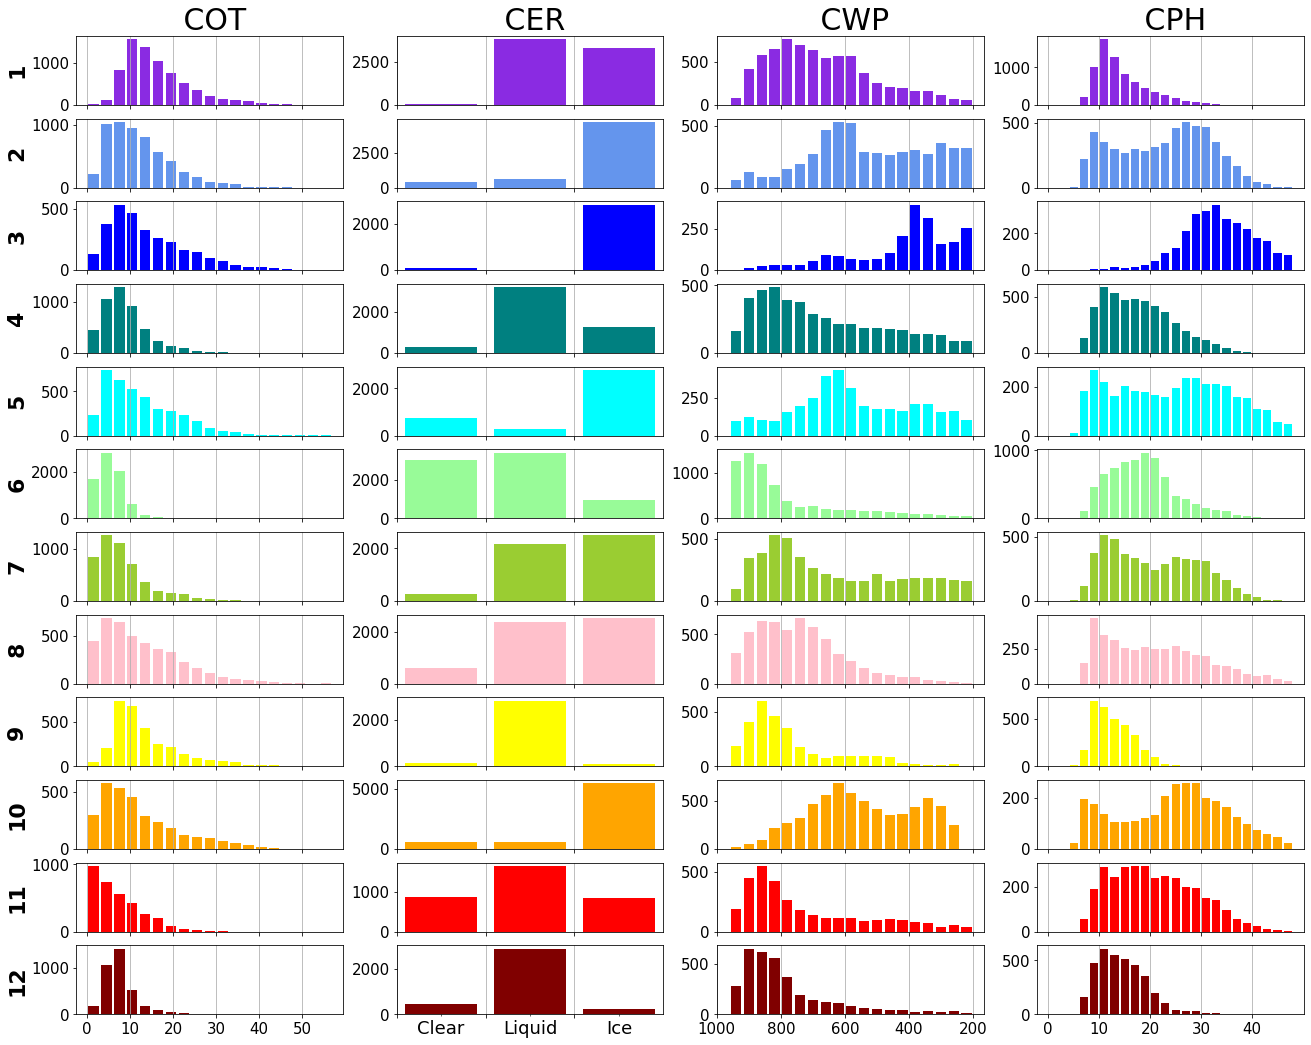

In [60]:
ckeys = [
        'Cloud_Optical_Thickness',
        'Cloud_Water_Path',
         'Cloud_Phase_Infrared_1km',
        'cloud_top_pressure_1km',
        'Cloud_Effective_Radius',
      ]
titles = ['COT','CTP','CER','CWP','CPH']
nclusters=12
clabels = label_results['12']['leaky_re_lu_23-labels']

cmap_name = 'my_list'
cmap = colors

matplotlib.rc('font',size=15)
fig = plt.figure(figsize=(22,18))
it = 1
phys_colors = ['b','c','y','r','g']
for iid, i in enumerate([i for i in range(nclusters)]):
    for k in [0,2,3,4]:
        ax = plt.subplot(nclusters, 4, it)
        #===============================================
        # change here
        #===============================================
        #tmp = agl_cimg_physics[i][:,k]
        m06_tmp =  np.array(m06_patchstats[f"mean-{ckeys[k]}"])
        #print(m06_tmp)
        #===============================================
        cindex = np.where(clabels == i)
        _tmp = m06_tmp[cindex]
        tmp = _tmp[np.logical_not(np.isnan(_tmp))] 
        #tmp = tmp[np.logical_not(np.isnan(tmp))]  
        
        if k == 0:
            plt.hist(tmp, bins=range(0, 60, 3), color=cmap[i],rwidth=.8)
            ax.set_ylabel(f"{i+1}", fontsize=22,  fontweight='bold')
            #ax.yaxis.set_label_coords(-.1, 5)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            plt.hist(tmp, bins=range(0, 1500, 75), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1500,400)])
        elif k == 2:
            iidx = np.where(tmp >=3)
            #print(len(iidx[0]))
            ax.set_xlim(0,3)
            tmp[iidx] = 3 
            plt.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,3,1)])
            if i == 11:
                ax.set_xlim(0,3)
                ax.set_xticklabels('')
                ax.set_xticks([.5,1.5,2.5,],      minor=True)
                #ax.set_xlim(0,4)
                #ax.set_xticklabels('')
                #ax.set_xticks([.5,1.5,2.5,3.5],      minor=True)
                ax.set_xticklabels(['Clear','Liquid','Ice',], minor=True, fontsize=18)
        elif k ==3:
            plt.hist(tmp, bins=range(200, 1000, 40), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(200,1001,200)])
            ax.invert_xaxis()
        elif k == 4: 
            plt.hist(tmp, bins=range(0, 50, 2), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,50,10)])
        
        if i == 0:
            ax.set_title(" %s" % titles[k],fontsize=30) 
        if i != 11:
            plt.setp(ax.get_xticklabels(), visible=False)
        it += 1
        plt.gca().xaxis.grid(True)
#plt.tight_layout()
fig.align_labels()

#plt.subplots_adjust(bottom=.4, hspace=.4)
#plt.savefig("Compare/cimg_04_20clusters_with-rad")
#plt.show()
#plt.close()
os.makedirs('./figs', exist_ok=True)
pdf = PdfPages(os.path.join('./figs', "hist_ri_phys_12_CUMULO.pdf"))
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

#### NRI

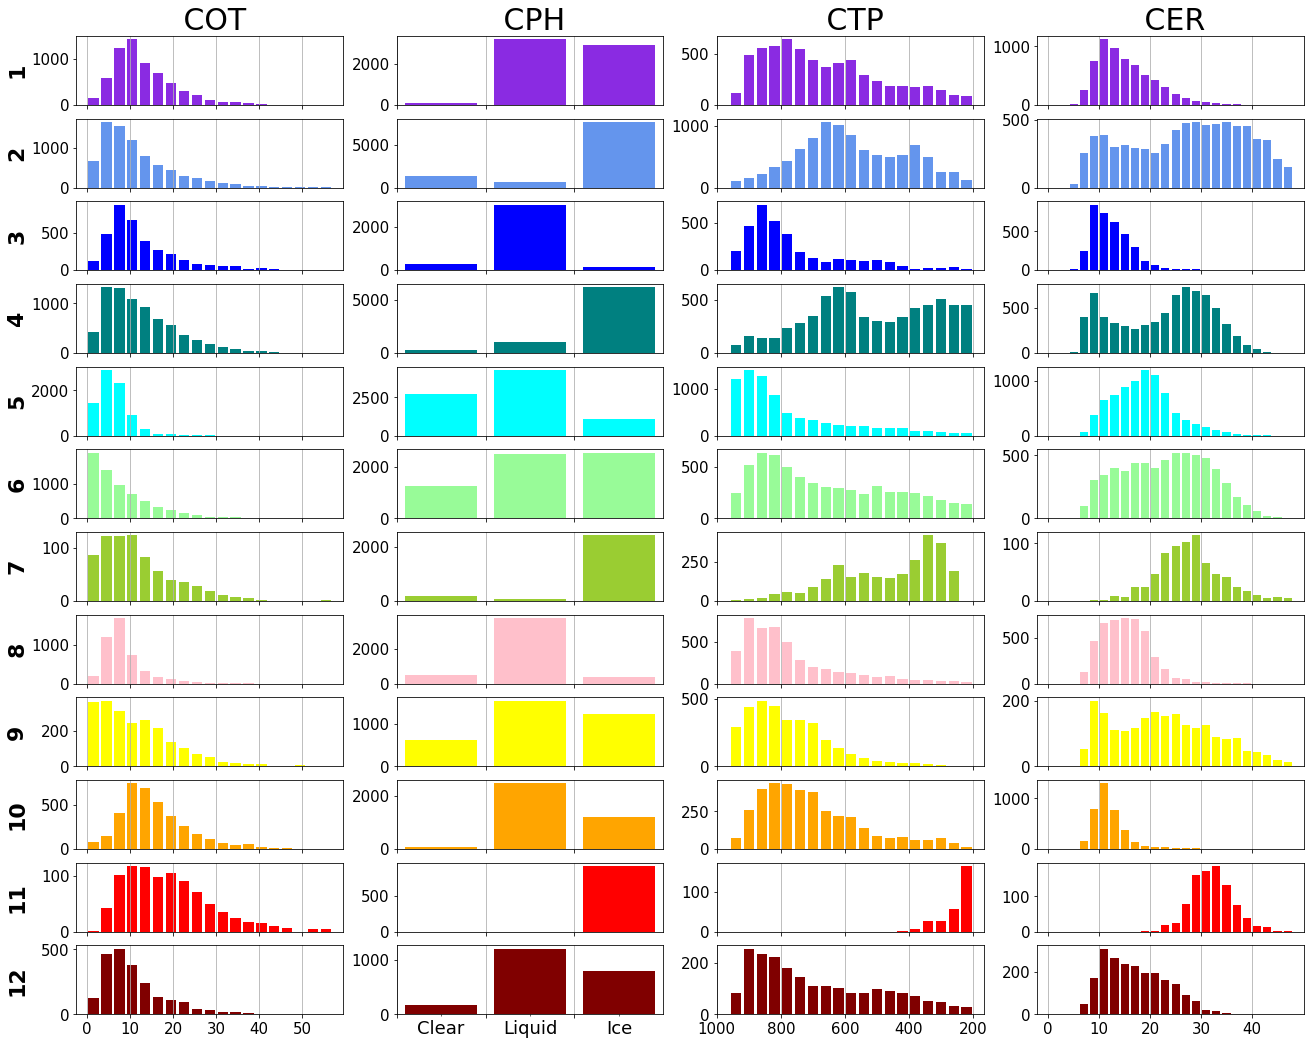

In [28]:
ckeys = [
        'Cloud_Optical_Thickness',
        'Cloud_Water_Path',
         'Cloud_Phase_Infrared_1km',
        'cloud_top_pressure_1km',
        'Cloud_Effective_Radius',
      ]
titles = ['COT','CWP','CPH','CTP','CER','CWP','CPH']
nclusters=12
clabels = label_results['12']['encoder-labels']

cmap_name = 'my_list'
cmap = colors

matplotlib.rc('font',size=15)
fig = plt.figure(figsize=(22,18))
it = 1
phys_colors = ['b','c','y','r','g']
for iid, i in enumerate([i for i in range(nclusters)]):
    for k in [0,2,3,4]:
        ax = plt.subplot(nclusters, 4, it)
        #===============================================
        # change here
        #===============================================
        #tmp = agl_cimg_physics[i][:,k]
        m06_tmp =  np.array(m06_patchstats[f"mean-{ckeys[k]}"])
        #print(m06_tmp)
        #===============================================
        cindex = np.where(clabels == i)
        _tmp = m06_tmp[cindex]
        tmp = _tmp[np.logical_not(np.isnan(_tmp))] 
        #tmp = tmp[np.logical_not(np.isnan(tmp))]  
        
        if k == 0:
            plt.hist(tmp, bins=range(0, 60, 3), color=cmap[i],rwidth=.8)
            ax.set_ylabel(f"{i+1}", fontsize=22,  fontweight='bold')
            #ax.yaxis.set_label_coords(-.1, 5)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            plt.hist(tmp, bins=range(0, 1500, 75), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1500,400)])
        elif k == 2:
            iidx = np.where(tmp >=3)
            #print(len(iidx[0]))
            ax.set_xlim(0,3)
            tmp[iidx] = 3 
            plt.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,3,1)])
            if i == 11:
                ax.set_xlim(0,3)
                ax.set_xticklabels('')
                ax.set_xticks([.5,1.5,2.5,],      minor=True)
                #ax.set_xlim(0,4)
                #ax.set_xticklabels('')
                #ax.set_xticks([.5,1.5,2.5,3.5],      minor=True)
                ax.set_xticklabels(['Clear','Liquid','Ice',], minor=True, fontsize=18)
        elif k ==3:
            plt.hist(tmp, bins=range(200, 1000, 40), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(200,1001,200)])
            ax.invert_xaxis()
        elif k == 4: 
            plt.hist(tmp, bins=range(0, 50, 2), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,50,10)])
        
        if i == 0:
            ax.set_title(" %s" % titles[k],fontsize=30) 
        if i != 11:
            plt.setp(ax.get_xticklabels(), visible=False)
        it += 1
        plt.gca().xaxis.grid(True)
#plt.tight_layout()
fig.align_labels()

#plt.subplots_adjust(bottom=.4, hspace=.4)
#plt.savefig("Compare/cimg_04_20clusters_with-rad")
#plt.show()
#plt.close()
os.makedirs('./figs', exist_ok=True)
pdf = PdfPages(os.path.join('./figs', "hist_nri_phys_12_CUMULO-Jan12008.pdf"))
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

### Visualization: Liquid and Ice 

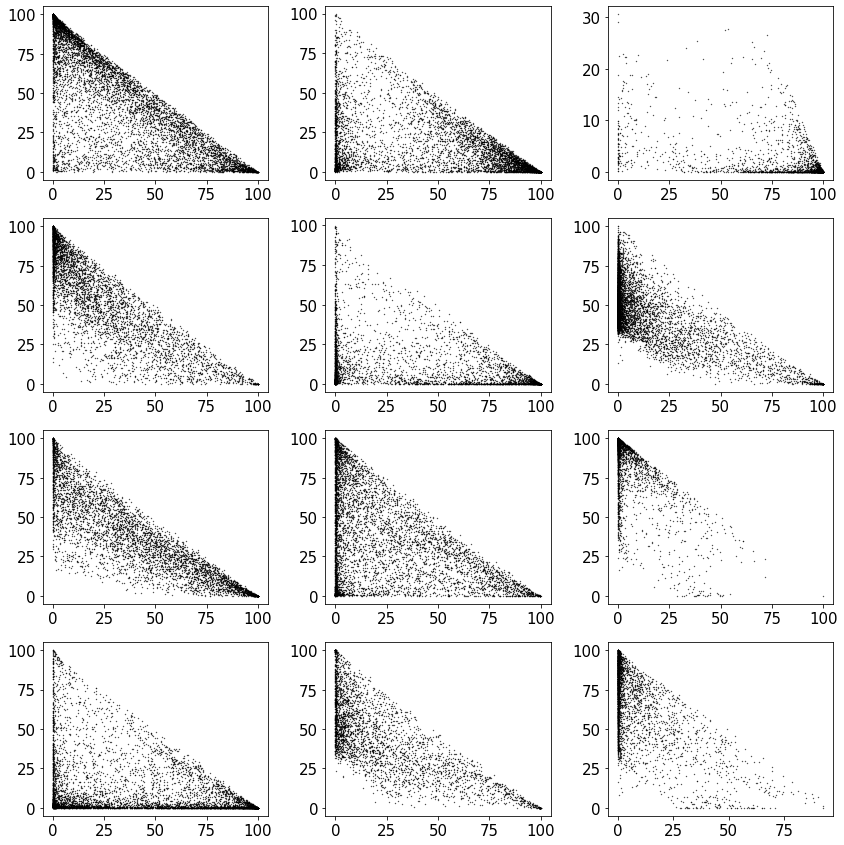

In [290]:
clabels = label_results['12']['leaky_re_lu_23-labels']
fig = plt.figure(figsize=(12,12))
alpha= 1/(128*128)*100
for idx, icluster in enumerate(range(12)):
    cdx = np.where(clabels == icluster)[0]
    _liquids = np.array(liquids)[cdx]*alpha
    _ices = np.array(ices)[cdx]*alpha
    ax = plt.subplot(4,3,idx+1)
    ax.scatter(_ices, _liquids, s=0.1,c='black')
fig.tight_layout()
plt.show()

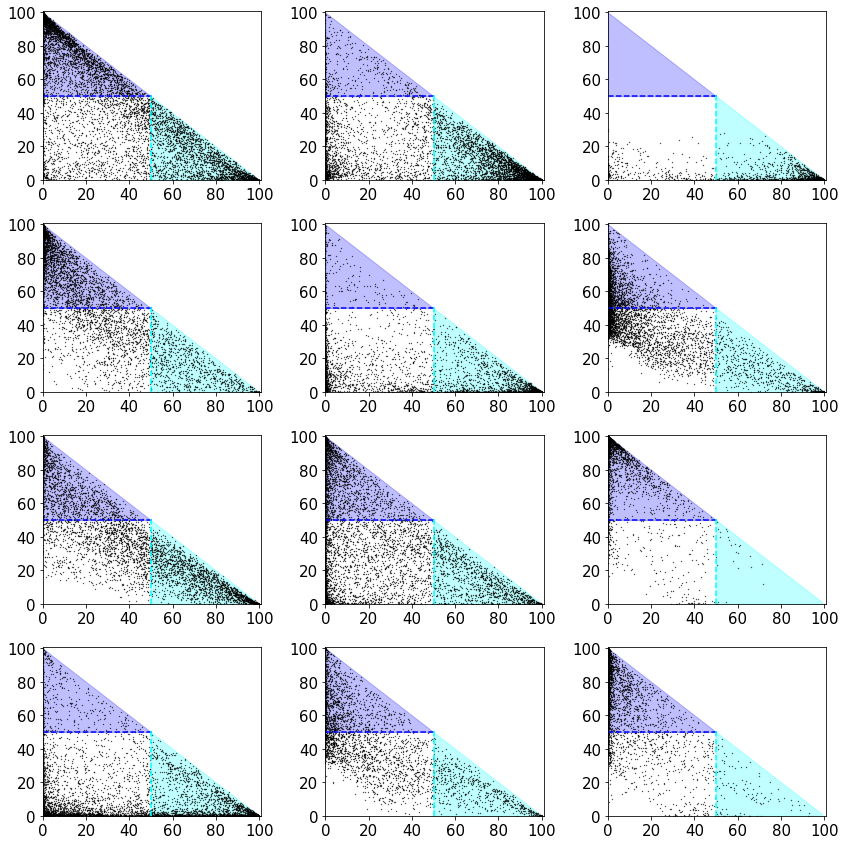

In [308]:
clabels = label_results['12']['leaky_re_lu_23-labels']
fig = plt.figure(figsize=(12,12))
alpha= 1/(128*128)*100
for idx, icluster in enumerate(range(12)):
    cdx = np.where(clabels == icluster)[0]
    _liquids = np.array(liquids)[cdx]*alpha
    _ices = np.array(ices)[cdx]*alpha
    ax = plt.subplot(4,3,idx+1)
    
    # fill
    xl = np.array([i for i in range(50)])
    y1 = 100-xl
    y2=50
    #liquid
    ax.fill_between(xl,y1,y2,
                    where=(y1>y2),
                    alpha=0.25,
                    color='blue'
                   )
    # ice
    x2 = np.array([i for i in range(50,100,1)])
    y1 = 100-x2
    y2=0
    ax.fill_between(x2,y1,y2,
                    where=(y1>y2),
                    alpha=0.25,
                    color='aqua'
                   )
    
    
    # plot
    ax.scatter(_ices, _liquids, s=0.1,c='black')
    #ax.set_axis_off()
    ax.set_xlim(0,101)
    ax.set_ylim(0,101)
    ax.set_xticks(np.arange(0,101,20))
    ax.set_yticks(np.arange(0,101,20))
    # add hline
    ax.axhline(y=50,xmin=0,xmax=.5,linestyle='--', color='blue')
    ax.axvline(x=50,ymin=0,ymax=.5,linestyle='--', color='aqua')
    

    
fig.tight_layout()
plt.show()

#### Save data

In [150]:
np.save('./ice_nums', np.array(ices))

In [354]:
np.save('./liquid_nums', np.array(liquids))

#### KDE plot

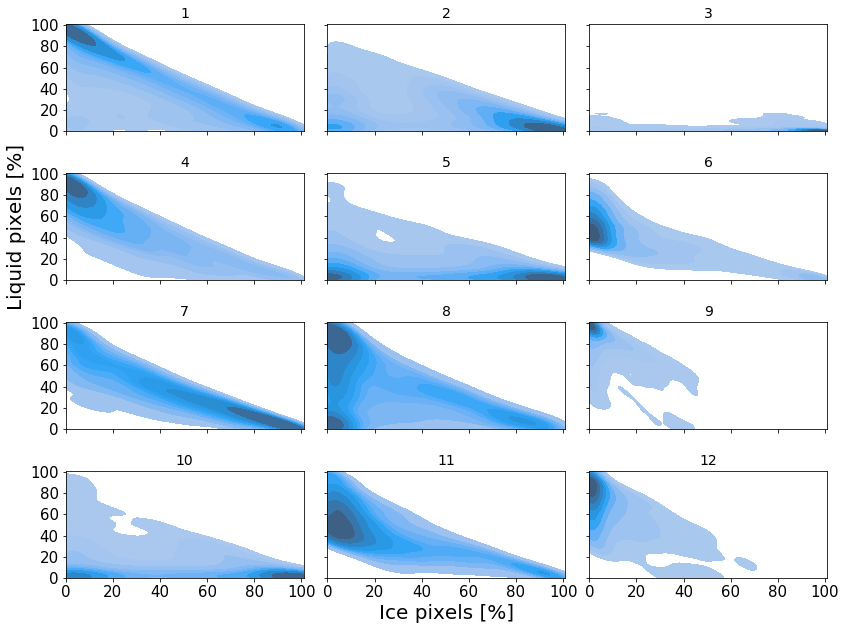

<Figure size 576x1152 with 0 Axes>

In [291]:
# Set up the matplotlib figure
f, axes = plt.subplots(4, 3, figsize=(12, 9), sharex=True, sharey=True)
newcmp = ListedColormap(colors)


clabels = label_results['12']['leaky_re_lu_23-labels']
fig = plt.figure(figsize=(8,16)) #12,14
alpha= 1/(128*128)*100
for idx, (ax,icluster) in enumerate(zip(axes.flat, range(12))) :
    cdx = np.where(clabels == icluster)[0]
    _liquids = np.array(liquids)[cdx]*alpha
    _ices = np.array(ices)[cdx]*alpha
    
    #sns.histplot(x=_ices, y=_liquids, bins=30,ax=ax,cmap='mako') #color=colors[idx] )
    sns.kdeplot(
        x=_ices, y=_liquids,
        palette='mako', fill=True,
        ax=ax,
        cbar=False,
    ) #color=colors[idx],
    #ax.set_axis_off()
    ax.set_xlim(0,101)
    ax.set_ylim(0,101)
    ax.set_xticks(np.arange(0,101,20))
    ax.set_yticks(np.arange(0,101,20))
    ax.set_title(f"{idx+1}", fontsize=14)
    
    if idx == 3:
        ax.set_ylabel("Liquid pixels [%]", fontsize=20)
    elif idx == 10:
        ax.set_xlabel("Ice pixels [%]", fontsize=20)

    ax.set_aspect(aspect='auto')
    
    # add hline
    #ax.axhline(y=50,xmin=0,xmax=.5,linestyle='--', color='black')
    #ax.axvline(x=50,ymin=0,ymax=.5,linestyle='--', color='black')
    #stop

#ax.set(xlim=(-3.5, 3.5), ylim=(-3.5, 3.5))
f.subplots_adjust(0, 0, 1, 1, .08, .08)
#f.tight_layout()
f.tight_layout( w_pad=.5)   
#plt.show()
os.makedirs('./figs', exist_ok=True)
pdf = PdfPages(os.path.join('./figs', "kde_percent_ice-liquid_12_CUMULO.pdf"))
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

In [ ]:
# Set up the matplotlib figure
f, axes = plt.subplots(4, 3, figsize=(12, 9), sharex=True, sharey=True)
newcmp = ListedColormap(colors)


clabels = label_results['12']['leaky_re_lu_23-labels']
fig = plt.figure(figsize=(8,16)) #12,14
alpha= 1/(128*128)*100
for idx, (ax,icluster) in enumerate(zip(axes.flat, range(12))) :
    cdx = np.where(clabels == icluster)[0]
    _liquids = np.array(liquids)[cdx]*alpha
    _ices = np.array(ices)[cdx]*alpha
    
    #sns.histplot(x=_ices, y=_liquids, bins=30,ax=ax,cmap='mako') #color=colors[idx] )
    sns.kdeplot(
        x=_ices, y=_liquids,
        palette='viridis', fill=True,
        ax=ax,
        cbar=True,
    ) #color=colors[idx],
    #ax.set_axis_off()
    ax.set_xlim(0,101)
    ax.set_ylim(0,101)
    ax.set_xticks(np.arange(0,101,20))
    ax.set_yticks(np.arange(0,101,20))
    ax.set_title(f"{idx+1}", fontsize=14)
    
    if idx == 3:
        ax.set_ylabel("Liquid pixels [%]", fontsize=20)
    elif idx == 10:
        ax.set_xlabel("Ice pixels [%]", fontsize=20)

    ax.set_aspect(aspect='auto')
    
    # add hline
    #ax.axhline(y=50,xmin=0,xmax=.5,linestyle='--', color='black')
    #ax.axvline(x=50,ymin=0,ymax=.5,linestyle='--', color='black')
    #stop

#ax.set(xlim=(-3.5, 3.5), ylim=(-3.5, 3.5))
f.subplots_adjust(0, 0, 1, 1, .08, .08)
#f.tight_layout()
#f.tight_layout( w_pad=.5)   
#plt.show()
os.makedirs('./figs', exist_ok=True)
pdf = PdfPages(os.path.join('./figs', "kde_percent_ice-liquid_12_CUMULO_cbar.pdf"))
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

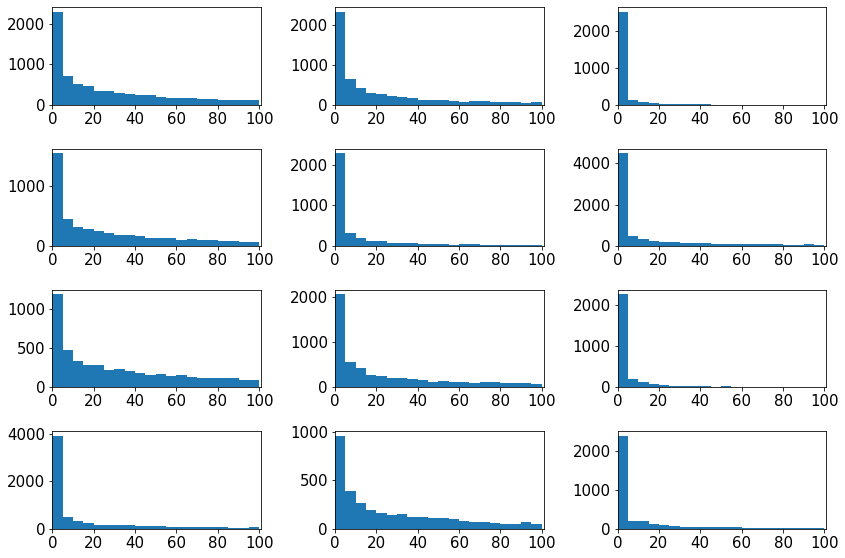

In [143]:
fig = plt.figure(figsize=(12,8))
cphs = m06_patchstats['stdv-Cloud_Phase_Infrared_1km']
for idx, icluster in enumerate(range(12)):
    cdx = np.where(clabels == icluster)[0]
    tmp = np.array(cphs)[cdx]
    #print(tmp);stop
    ax = plt.subplot(4,3,idx+1)
    ax.hist(tmp, bins=np.arange(0,101,5), )
    ax.set_xlim(0,101)
    ax.set_xticks(np.arange(0,101,20))
fig.tight_layout()
plt.show()

-----------------------------------
### About cluster 8

In [ ]:
fig = plt.figure(figsize=(13,13))
for i in range(12):
    iii = i+1
    ax = plt.subplot(3,4,iii)
    x = tmp_stdvs[i]
    y  = tmp_mean[i]
    sns.kdeplot(
        x=x, y=y,
        cmap='mako', fill=True,ax = ax,)
    ax.set_ylim(1000,0)
    ax.set_xlim(0,380)
    ax.set_title(i, fontsize=14)
fig.tight_layout()

#pdf = PdfPages(os.path.join('./figs', 'kde_20080101-n12-statCTP.pdf'))
#plt.savefig(pdf, format='pdf', bbox_inches = 'tight')
plt.show()
#pdf.close()
#pdf = None

--------------------------
### Visualization: Histogram + 2 figures
```
cluster-0 [4002 4001 3374 4909 4018 3378  549 6318  439 4017 3382 2683]
cluster-1 [1582 3669 3660 1586 5528 3665 1580 3066 5616 1124 1162 5524]
cluster-2 [2051 2194 2200 1313 2224 2858 2056 2225 2207 2206 1598 2215]
cluster-3 [2074 2660 2082 2109  400 2066 3246 2024 2661 2311 2659 2075]
cluster-4 [2996 2133 1966 1973 2127 1693 1894 2998 1910 1872 1684 1911]
cluster-5 [4260 4249 2802 1407 1389  153 4202 4269 4231 4219 1388  143]
cluster-6 [2533 2816 2824 2534 2825 2833 2826 2560 2525 2250 1537 4845]
cluster-7 [5160 3971 3985 3970 3984 3972 3986 5318 5161 5175 5174 5176]
cluster-8 [  41 2649 2625 2654 2624   39 2629 1278 1523 2626 1516 1509]
cluster-9 [1507 4651 4649 4650 4670 4723 2901 1396 4671 1472 4997 4686]
cluster-10 [ 953  957   63  952   41   48 3165   54 3176   68 1732  951]
cluster-11 [3411 3412 1075 2974 2551 2026 2529   60 3399 3402 2975 2557]

```

- RI autoencoder

In [32]:
ncentroids = {
    "cluster-0":  [4002, 4001, 3374, 4909, 4018, 3378,  549, 6318,  439, 4017, 3382, 2683],
    "cluster-1":  [1582, 3669, 3660, 1586, 5528, 3665, 1580, 3066, 5616, 1124, 1162, 5524],
    "cluster-2":  [2051, 2194, 2200, 1313, 2224, 2858, 2056, 2225, 2207, 2206, 1598, 2215],
    "cluster-3":  [2074, 2660, 2082, 2109,  400, 2066, 3246, 2024, 2661, 2311, 2659, 2075],
    "cluster-4":  [2996, 2133, 1966, 1973, 2127, 1693, 1894, 2998, 1910, 1872, 1684, 1911],
    "cluster-5":  [4260, 4249, 2802, 1407, 1389,  153, 4202, 4269, 4231, 4219, 1388,  143],
    "cluster-6":  [2533, 2816, 2824, 2534, 2825, 2833, 2826, 2560, 2525, 2250, 1537, 4845],
    "cluster-7":  [5160, 3971, 3985, 3970, 3984, 3972, 3986, 5318, 5161, 5175, 5174, 5176],
    "cluster-8":  [  41, 2649, 2625, 2654, 2624,   39, 2629, 1278, 1523, 2626, 1516, 1509],
    "cluster-9 ": [1507, 4651, 4649, 4650, 4670, 4723, 2901, 1396, 4671, 1472, 4997, 4686],
    "cluster-10":  [ 953, 957,   63,  952,   41,   48, 3165,   54, 3176,   68, 1732,  951],
    "cluster-11":  [3411,3412, 1075, 2974, 2551, 2026, 2529,   60, 3399, 3402, 2975, 2557],
}

- NRI autoencoder

In [32]:
"1321  942 1311  918  923 5247  934 3680  915 3715 1322  943 3672 5242 3716 3708 5260  456  442 5328"

['1321',
 '942',
 '1311',
 '918',
 '923',
 '5247',
 '934',
 '3680',
 '915',
 '3715',
 '1322',
 '943',
 '3672',
 '5242',
 '3716',
 '3708',
 '5260',
 '456',
 '442',
 '5328']

In [34]:
ncentroids = {
"cluster-0": [1321, 942, 1311, 918, 923, 5247, 934, 3680, 915, 3715, 1322, 943, 3672, 5242, 3716, 3708, 5260, 456, 442, 5328],
"cluster-1": [7577, 7578, 7591, 7617, 7592, 3466, 7651, 6905, 6906, 7650, 7632, 6909, 6924, 7602, 4690, 6923, 7616, 1153, 4684, 4741],
"cluster-2": [72, 3114, 3091, 70, 3113, 2530, 3090, 1153, 1059, 3109, 3108, 2597, 1143, 3125, 2522, 3395, 2307, 80, 3107, 2762],
"cluster-3": [1448, 1428, 2107, 1423, 1436, 3116, 1432, 1418, 1424, 1419, 7193, 3111, 7191, 2106, 2606, 1429, 1383, 670, 1414, 3364],
"cluster-4": [4716, 180, 1494, 7702, 7711, 4725, 7678, 4738, 4705, 4749, 4717, 7736, 173, 7687, 1493, 7741, 1476, 1489, 7756, 1490],
"cluster-5": [652, 752, 3741, 759, 3733, 4058, 748, 3133, 5972, 753, 1238, 3521, 651, 764, 637, 6118, 5658, 773, 758, 3740],
"cluster-6": [311, 303, 319, 332, 143, 339, 302, 142, 1928, 37, 1859, 1854, 730, 325, 338, 1410, 719, 1938, 293, 1687],
"cluster-7": [1243, 3779, 2708, 2739, 1249, 3789, 3801, 1237, 2714, 2735, 2711, 113, 2744, 1248, 1929, 1264, 3800, 3788, 2710, 2738],
"cluster-8": [2362, 2353, 3180, 2363, 3181, 1832, 1819, 2354, 1825, 210, 3193, 3192, 2355, 1338, 910, 618, 1547, 1826, 2361, 2364],
"cluster-9": [3066, 2903, 3053, 2412, 1937, 2113, 2175, 2893, 2100, 3078, 2407, 2388, 2395, 36, 3125, 3296, 40, 1986, 2088, 2915],
"cluster-10": [408, 377, 378, 391, 390, 318, 409, 406, 700, 400, 405, 17, 185, 36, 914, 694, 412, 57, 407, 413],
"cluster-11": [1859, 1861, 2137, 1857, 1856, 1258, 1685, 1257, 1611, 730, 727, 191, 568, 724, 1639, 2121, 2138, 63, 2134, 729],
}

#### load vis band

In [35]:
hdf_datadir='/home/tkurihana/hdd1/data/MYD02/20080101'

In [36]:
def zscore(data):
    return (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))

In [37]:
def proc_msds(sds_array):
    """
    Multi-band
    IN: array = hdf_data.select(variable_name)
    """
    array = sds_array.get()
    array = array.astype(np.float64)
    
    # check bandinfo
    _bands = sds_array.attributes()['band_names']
    #print("Process bands", _bands)
    bands = _bands.split(",")
    
    # nan process
    nan_idx = np.where( array == sds_array.attributes()['_FillValue'])
    if len(nan_idx) > 0:
        array[nan_idx] = np.nan
    else:
        pass
    # invalid value process
    # TODO: future change 32767 to other value
    invalid_idx = np.where( array > 32767 )
    if len(nan_idx) > 0:
        array[invalid_idx] = np.nan
    else:
        pass
    
    # radiacne offset
    offset = sds_array.attributes()['radiance_offsets']
    offset_array = np.zeros(array.shape) # new matrix
    offset_ones  = np.ones(array.shape)  # 1 Matrix 
    for iband in range(len(offset)):
        offset_array[iband, :,:] = array[iband, :,:] - offset[iband]*offset_ones[iband,:,:]
    
    # radiance scale
    scales = sds_array.attributes()['radiance_scales']
    scales_array = np.zeros(array.shape) # new matrix
    for iband in range(len(offset)):
        scales_array[iband,:,:] = scales[iband]*offset_array[iband,:,:]
    return scales_array, bands

In [38]:
clouds_vimgs = []
idx = 20
h=w=128
for idx, i in enumerate(fileorder):
    fbasename = os.path.basename(i).rstrip('.tfrecord')
    fbname = re.findall(r'A[0-9]{7}.[0-9]{4}', fbasename)[0].split('.')
    ctime = fbname[1]
    # HDF data
    try:
        vis_file = glob.glob(os.path.join(hdf_datadir,
                        f"MYD021KM.A2008001.{ctime}.*.hdf"
                       ))[0]
        vhdf = SD(vis_file, SDC.READ)
        vhdf_sds250 = vhdf.select("EV_250_Aggr1km_RefSB")
        #vhdf_sds500 = vhdf.select("EV_500_Aggr1km_RefSB")
        v250,_ = proc_msds(vhdf_sds250)
        #v500,_ = proc_msds(vhdf_sds500)
        
        vhdf_array = zscore(v250[0])
        #vhdf_array = zscore(v500[2])
        
        for coord in coords_list[idx]:
            x= coord[0]
            y= coord[1]
            im = Image.fromarray(np.uint8(vhdf_array[x:x+h,y:y+w]*255)).convert('RGB')
            clouds_vimgs.append( im )
    
        if idx % 20 == 0:
            print(f"{idx} files read done!", flush=True)
            gc.collect()
    except Exception as e:
        print(e)

0 files read done!


/home/tkurihana/.conda/envs/tf-cpu/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in greater


20 files read done!
40 files read done!
60 files read done!
80 files read done!
100 files read done!
120 files read done!
140 files read done!


##### cloud_imgs_dict

In [39]:
cloud_imgs_dict = {}
for icluster, (ikey, item) in enumerate(ncentroids.items()):
    ig_list = []
    cdx = np.where(clabels == icluster)[0]
    print(cdx)
    for i in item:
        print(cdx[i])
        ig_list.append(clouds_vimgs[cdx[i]] )
    cloud_imgs_dict[ikey] = ig_list

[  416   504   535 ... 58724 58725 58733]
14195
10055
14177
9992
10011
48543
10038
33438
9973
33510
14196
10056
33418
48521
33511
33490
48642
5632
5611
48801
[    7     8    10 ... 58519 58539 58601]
47654
47655
47673
47711
47674
21072
47749
43857
43858
47748
47729
43861
43876
47692
28492
43875
47710
8867
28472
28626
[  917   927   928 ... 58699 58700 58707]
3561
51291
51256
3541
51290
45855
51255
26193
23028
51282
51281
45960
26172
51434
45840
55226
41585
3655
51280
46268
[  156   169   182 ... 58726 58727 58728]
9720
9666
13981
9651
9692
21769
9682
9635
9652
9636
57439
21755
57428
13980
17789
9667
8871
5186
9619
24181
[ 1206  1244  1277 ... 58669 58684 58723]
34608
2020
7879
54987
55003
34621
54949
34637
34596
34652
34609
55031
2005
54961
7878
55039
7860
7874
55055
7875
[  349   367   500 ... 58717 58729 58730]
4394
6504
35908
6519
35888
39471
6489
31778
55932
6505
8565
35506
4393
6532
4374
56236
51805
6587
6518
35907
[    5     6     9 ... 57340 57352 57364]
4945
4926
4965
4997
4585

In [40]:
cloud_imgs_dict.keys()

dict_keys(['cluster-0', 'cluster-1', 'cluster-2', 'cluster-3', 'cluster-4', 'cluster-5', 'cluster-6', 'cluster-7', 'cluster-8', 'cluster-9', 'cluster-10', 'cluster-11'])

In [41]:
gridsize=(12,6)
print([(2*i,j) for  i in range(12) for j in range(4)]+[(i,j) for  i in range(12) for j in range(8,10,1)])

[(0, 0), (0, 1), (0, 2), (0, 3), (2, 0), (2, 1), (2, 2), (2, 3), (4, 0), (4, 1), (4, 2), (4, 3), (6, 0), (6, 1), (6, 2), (6, 3), (8, 0), (8, 1), (8, 2), (8, 3), (10, 0), (10, 1), (10, 2), (10, 3), (12, 0), (12, 1), (12, 2), (12, 3), (14, 0), (14, 1), (14, 2), (14, 3), (16, 0), (16, 1), (16, 2), (16, 3), (18, 0), (18, 1), (18, 2), (18, 3), (20, 0), (20, 1), (20, 2), (20, 3), (22, 0), (22, 1), (22, 2), (22, 3), (0, 8), (0, 9), (1, 8), (1, 9), (2, 8), (2, 9), (3, 8), (3, 9), (4, 8), (4, 9), (5, 8), (5, 9), (6, 8), (6, 9), (7, 8), (7, 9), (8, 8), (8, 9), (9, 8), (9, 9), (10, 8), (10, 9), (11, 8), (11, 9)]


#### RI autoencoder

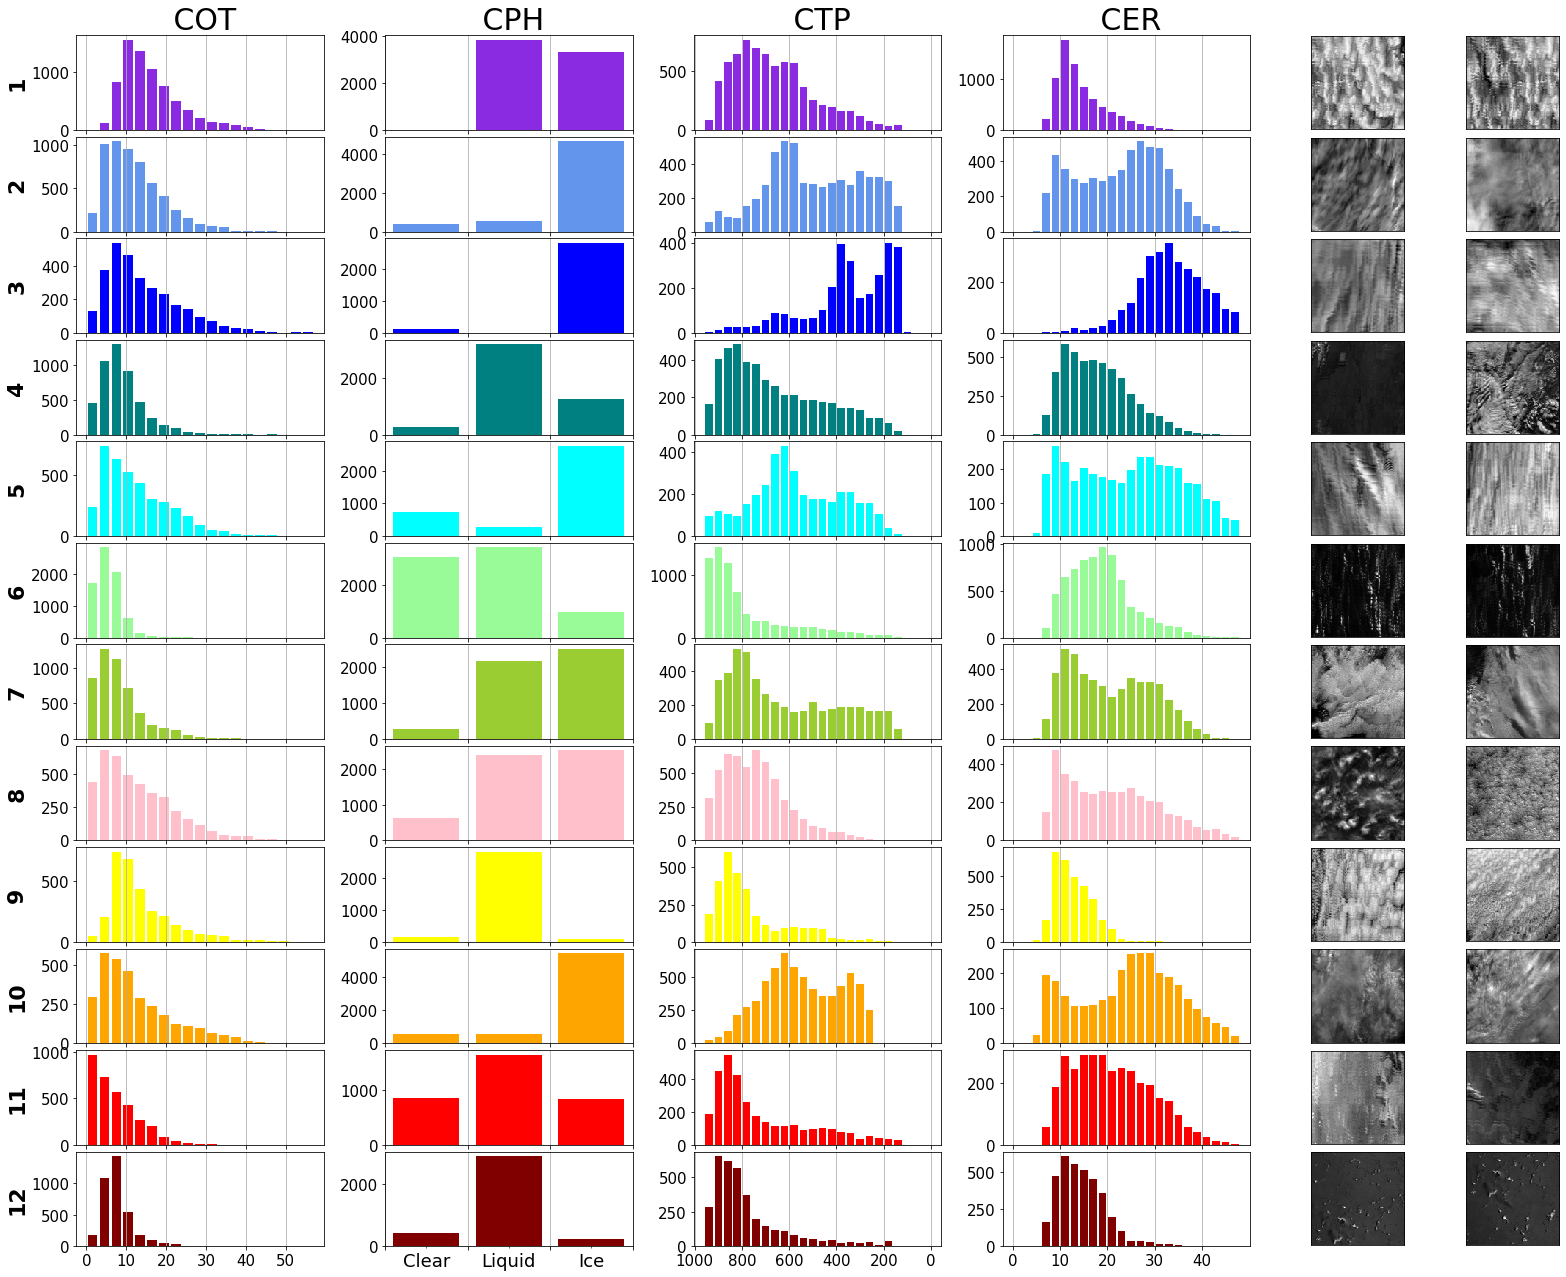

In [62]:
ckeys = [
        'Cloud_Optical_Thickness',
        'Cloud_Water_Path', 
        'Cloud_Phase_Infrared_1km',
        'cloud_top_pressure_1km',
        'Cloud_Effective_Radius',
      ]
titles = ['COT','CWP','CPH','CTP','CER'] #0,2,3,4 OT,PH,TopP, CER
nclusters=12
clabels = label_results['12']['leaky_re_lu_23-labels']

cmap_name = 'my_list'
cmap = colors

matplotlib.rc('font',size=15)
fig = plt.figure(figsize=(22,18))
gridsize = (24,20) #(7,4)
axs= [plt.subplot2grid(gridsize, (2*i, 2*j),colspan=2*2, rowspan=2*1) for i in range(12) for j in range(0,8,2)]+[
    plt.subplot2grid(gridsize, (2*i, 2*j),colspan=2*1, rowspan=2*1) for i in range(12) for j in range(8,10,1)
]

#### histogram
it = 0
phys_colors = ['b','c','y','r','g']
for iid, i in enumerate([i for i in range(nclusters)]):
    for k in [0,2,3,4]:
        #ax = plt.subplot(nclusters, , it)
        ax = axs[it]
        m06_tmp =  np.array(m06_patchstats[f"mean-{ckeys[k]}"])
        cindex = np.where(clabels == i)
        _tmp = m06_tmp[cindex]
        tmp = _tmp[np.logical_not(np.isnan(_tmp))]  
        
        if k == 0:
            ax.hist(tmp, bins=range(0, 60, 3), color=cmap[i],rwidth=.8)
            ax.set_ylabel(f"{i+1}", fontsize=22,  fontweight='bold')
            #ax.yaxis.set_label_coords(-.1, 5)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            ax.hist(tmp, bins=range(0, 1500, 75), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1500,400)])
        elif k == 2:
            iidx = np.where(tmp >=3)
            ax.set_xlim(0,3)
            tmp[iidx] = 3 
            ax.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,4,1)])
            #ax.set_xlim(0,4)
            #tmp[iidx] = 3 
            #ax.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            #ax.set_xticks([l for l in range(0,4,1)])
            if i == 11:
                ax.set_xlim(0,3)
                ax.set_xticklabels('')
                ax.set_xticks([.5,1.5,2.5,],      minor=True)
                ax.set_xticklabels(['Clear','Liquid','Ice',], minor=True, fontsize=18)
                #ax.set_xlim(0,4)
                #ax.set_xticklabels('')
                #ax.set_xticks([.5,1.5,2.5,3.5],      minor=True)
                #ax.set_xticklabels(['Clear','Liquid','Ice','Undef'], minor=True, fontsize=18)
        elif k ==3:
            ax.hist(tmp, bins=range(0, 1000, 40), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1001,200)])
            ax.invert_xaxis()
        elif k == 4: 
            ax.hist(tmp, bins=range(0, 50, 2), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,50,10)])
        
        if i == 0:
            ax.set_title(" %s" % titles[k],fontsize=30) 
        if i != 11:
            #plt.setp(ax.get_xticklabels(), visible=False)
            ax.set_xticklabels([])
        it += 1
        #plt.gca().xaxis.grid(True)
        ax.grid(True,axis="x")


fig.tight_layout(pad=.5, w_pad=.5, h_pad=.5)
fig.align_labels()
####
for ikey in cloud_imgs_dict.keys():
    cloud_vimgs = cloud_imgs_dict[ikey]
    #stop
    for j in range(2):
        ax = axs[it]
        ax.imshow(np.asarray(cloud_vimgs[j])[:,:,0],cmap='gist_gray' )
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        it +=1
fig.tight_layout( h_pad=-.5)
os.makedirs('./figs', exist_ok=True)
pdf = PdfPages(os.path.join('./figs', "hist_Imgaes_ri_phys_12_CUMULO.pdf"))
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

#### NRI autoencoder

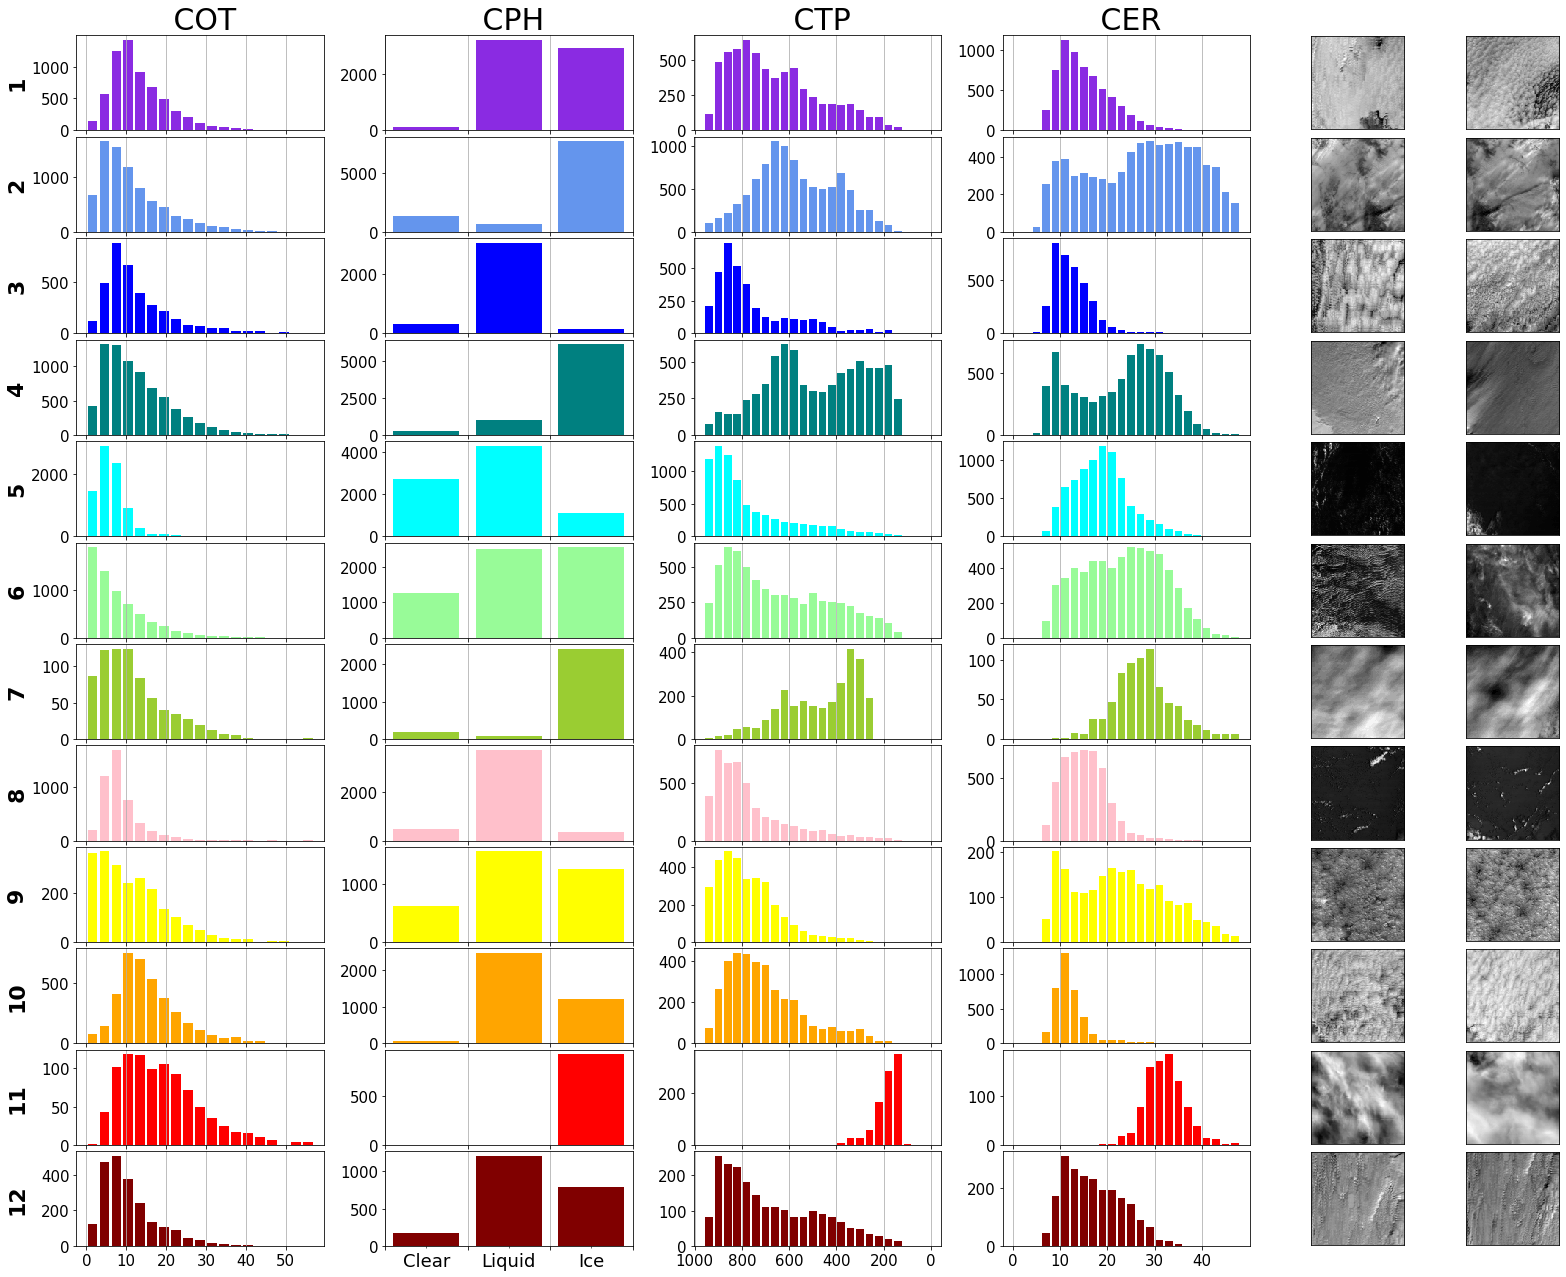

In [42]:
ckeys = [
        'Cloud_Optical_Thickness',
        'Cloud_Water_Path', 
        'Cloud_Phase_Infrared_1km',
        'cloud_top_pressure_1km',
        'Cloud_Effective_Radius',
      ]
titles = ['COT','CWP','CPH','CTP','CER'] #0,2,3,4 OT,PH,TopP, CER
nclusters=12
clabels = label_results['12']['encoder-labels']

cmap_name = 'my_list'
cmap = colors

matplotlib.rc('font',size=15)
fig = plt.figure(figsize=(22,18))
gridsize = (24,20) #(7,4)
axs= [plt.subplot2grid(gridsize, (2*i, 2*j),colspan=2*2, rowspan=2*1) for i in range(12) for j in range(0,8,2)]+[
    plt.subplot2grid(gridsize, (2*i, 2*j),colspan=2*1, rowspan=2*1) for i in range(12) for j in range(8,10,1)
]

#### histogram
it = 0
phys_colors = ['b','c','y','r','g']
for iid, i in enumerate([i for i in range(nclusters)]):
    for k in [0,2,3,4]:
        #ax = plt.subplot(nclusters, , it)
        ax = axs[it]
        m06_tmp =  np.array(m06_patchstats[f"mean-{ckeys[k]}"])
        cindex = np.where(clabels == i)
        _tmp = m06_tmp[cindex]
        tmp = _tmp[np.logical_not(np.isnan(_tmp))]  
        
        if k == 0:
            ax.hist(tmp, bins=range(0, 60, 3), color=cmap[i],rwidth=.8)
            ax.set_ylabel(f"{i+1}", fontsize=22,  fontweight='bold')
            #ax.yaxis.set_label_coords(-.1, 5)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            ax.hist(tmp, bins=range(0, 1500, 75), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1500,400)])
        elif k == 2:
            iidx = np.where(tmp >=3)
            ax.set_xlim(0,3)
            tmp[iidx] = 3 
            ax.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,4,1)])
            #ax.set_xlim(0,4)
            #tmp[iidx] = 3 
            #ax.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            #ax.set_xticks([l for l in range(0,4,1)])
            if i == 11:
                ax.set_xlim(0,3)
                ax.set_xticklabels('')
                ax.set_xticks([.5,1.5,2.5,],      minor=True)
                ax.set_xticklabels(['Clear','Liquid','Ice',], minor=True, fontsize=18)
                #ax.set_xlim(0,4)
                #ax.set_xticklabels('')
                #ax.set_xticks([.5,1.5,2.5,3.5],      minor=True)
                #ax.set_xticklabels(['Clear','Liquid','Ice','Undef'], minor=True, fontsize=18)
        elif k ==3:
            ax.hist(tmp, bins=range(0, 1000, 40), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1001,200)])
            ax.invert_xaxis()
        elif k == 4: 
            ax.hist(tmp, bins=range(0, 50, 2), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,50,10)])
        
        if i == 0:
            ax.set_title(" %s" % titles[k],fontsize=30) 
        if i != 11:
            #plt.setp(ax.get_xticklabels(), visible=False)
            ax.set_xticklabels([])
        it += 1
        #plt.gca().xaxis.grid(True)
        ax.grid(True,axis="x")


fig.tight_layout(pad=.5, w_pad=.5, h_pad=.5)
fig.align_labels()
####
for ikey in cloud_imgs_dict.keys():
    cloud_vimgs = cloud_imgs_dict[ikey]
    #stop
    for j in range(2):
        ax = axs[it]
        ax.imshow(np.asarray(cloud_vimgs[j])[:,:,0],cmap='gist_gray' )
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        it +=1
fig.tight_layout( h_pad=-.5)
os.makedirs('./figs', exist_ok=True)
pdf = PdfPages(os.path.join('./figs', "hist_Imgaes_nri_phys_12_CUMULO.pdf"))
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None

#### Make indivisual graph

- Variables

In [238]:
def base_hplot(m06_patchstats=None,clabels=None,kindex=None, cmap=None,
               ckeys={},gridsize=None,
               nclusters=12,figsize=(10,20), fsize=15 ):
    """ kindex [0,2,3,4] for ckeys
    """
    matplotlib.rc('font',size=fsize)
    fig = plt.figure(figsize=figsize )
    axs= [plt.subplot2grid(gridsize, (i, 0),colspan=1, rowspan=1) for i in range(12)]
    #print(axs);stop
    ckeys = [
        'Cloud_Optical_Thickness',
        'Cloud_Water_Path', 
        'Cloud_Phase_Infrared_1km',
        'cloud_top_pressure_1km',
        'Cloud_Effective_Radius',
      ]
    titles = ['COT','CWP','CPH','CTP','CER'] #0,2,3,4 OT,PH,TopP, CER
    #clabels = label_results[f'{}']['leaky_re_lu_23-labels']

    #cmap_name = 'my_list'
    #cmap = colors
    
    it=0
    for  iid, i in enumerate(range(nclusters)):
        for k in [kindex]:
            #print(i,k)
            ax = axs[it]
            m06_tmp =  np.array(m06_patchstats[f"mean-{ckeys[k]}"])
            cindex = np.where(clabels == i)
            _tmp = m06_tmp[cindex]
            tmp = _tmp[np.logical_not(np.isnan(_tmp))]  
        
            if k == 0:
                ax.hist(tmp, bins=range(0, 60, 3), color=cmap[i],rwidth=.8)
                ax.set_ylabel(f"{i+1}", fontsize=22,  fontweight='bold')
                #ax.yaxis.set_label_coords(-.1, 5)
                ax.set_xticks([l for l in range(0,60, 10)])
            elif k ==1 :
                ax.hist(tmp, bins=range(0, 1500, 75), color=cmap[i],rwidth=.8)
                ax.set_xticks([l for l in range(0,1500,400)])
            elif k == 2:
                iidx = np.where(tmp >=5)
                ax.set_xlim(0,4)
                tmp[iidx] = 3 
                ax.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
                ax.set_xticks([l for l in range(0,4,1)])
                if i == 11:
                    ax.set_xlim(0,4)
                    ax.set_xticklabels('')
                    ax.set_xticks([.5,1.5,2.5,3.5],      minor=True)
                    ax.set_xticklabels(['Clear','Liquid','Ice',''], minor=True, fontsize=18)
            elif k ==3:
                ax.hist(tmp, bins=range(200, 1000, 40), color=cmap[i],rwidth=.8)
                ax.set_xticks([l for l in range(200,1001,200)])
                ax.invert_xaxis()
            elif k == 4: 
                ax.hist(tmp, bins=range(0, 50, 2), color=cmap[i],rwidth=.8)
                ax.set_xticks([l for l in range(0,50,10)])
        
            if i == 0:
                ax.set_title(" %s" % titles[k],fontsize=30) 
            if i != 11:
                #plt.setp(ax.get_xticklabels(), visible=False)
                ax.set_xticklabels([])
            it += 1
            #plt.gca().xaxis.grid(True)
            ax.grid(True,axis="x")
    fig.tight_layout(pad=.5, w_pad=.5, h_pad=.5)
    fig.align_labels()
    #plt.show()
    os.makedirs('./figs', exist_ok=True)
    pdf = PdfPages(os.path.join('./figs', f"hist_{titles[k]}_ri_phys_12_CUMULO.pdf"))
    plt.savefig(pdf, format='pdf', bbox_inches='tight')
    pdf.close()
    pdf = None

In [162]:
ckeys = [
        'Cloud_Optical_Thickness',
        'Cloud_Water_Path',
         'Cloud_Phase_Infrared_1km',
        'cloud_top_pressure_1km',
        'Cloud_Effective_Radius',
      ]
titles = ['COT','CTP','CER','CWP','CPH']
nclusters=12
clabels = label_results['12']['leaky_re_lu_23-labels']
cmap = colors

In [ ]:
base_hplot(m06_patchstats,clabels,kindex=4, cmap=cmap,gridsize = (12,2),
            ckeys=ckeys,nclusters=12,figsize=(10,20), fsize=15 )

- Images

In [267]:
def base_Imageplot(cloud_imgs_dict={},
                   clabels=None,kindex=None, cmap=None,
                   ckeys={},gridsize=None,
                   nclusters=12,figsize=(10,20), fsize=15 ):
    """ kindex [0,2,3,4] for ckeys
    """
    matplotlib.rc('font',size=fsize)
    fig = plt.figure(figsize=figsize )
    axs= [plt.subplot2grid(gridsize, (i, j),colspan=1, rowspan=1) for i in range(12) for j in range(2)]
    #print(axs);stop
    ckeys = [
        'Cloud_Optical_Thickness',
        'Cloud_Water_Path', 
        'Cloud_Phase_Infrared_1km',
        'cloud_top_pressure_1km',
        'Cloud_Effective_Radius',
      ]
    titles = ['COT','CWP','CPH','CTP','CER'] #0,2,3,4 OT,PH,TopP, CER

    it = 0
    for ikey in cloud_imgs_dict.keys():
        cloud_vimgs = cloud_imgs_dict[ikey]
        #stop
        for j in range(2):
            ax = axs[it]
            ax.imshow(np.asarray(cloud_vimgs[j])[:,:,0],cmap='gist_gray' )
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)
            it +=1
    fig.tight_layout(pad=.5, w_pad=.5, h_pad=.5)
    fig.tight_layout( h_pad=.5)
    
    #plt.show()
    os.makedirs('./figs', exist_ok=True)
    pdf = PdfPages(os.path.join('./figs', "Image_ri_phys_12_CUMULO.pdf"))
    plt.savefig(pdf, format='pdf', bbox_inches='tight')
    pdf.close()
    pdf = None

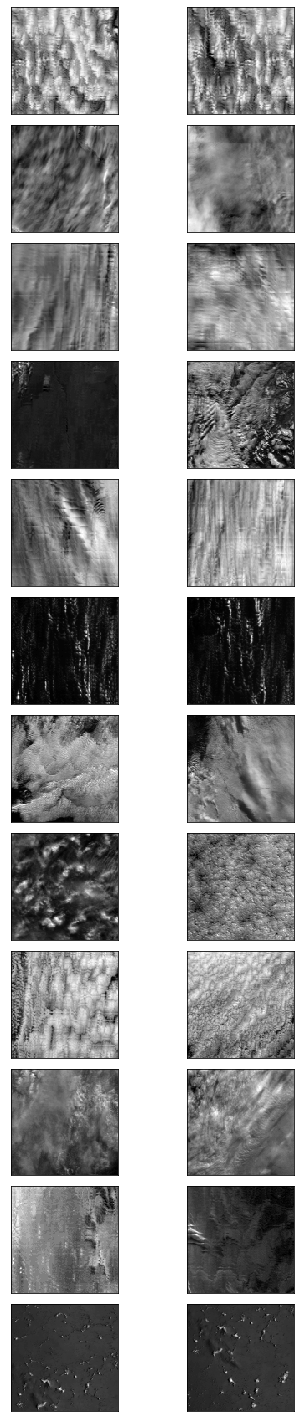

In [268]:
base_Imageplot(cloud_imgs_dict,clabels,kindex=4, cmap=cmap,gridsize = (12,4),
            ckeys=ckeys,nclusters=12,figsize=(10,20), fsize=15 )

In [ ]:
ckeys = [
        'Cloud_Optical_Thickness',
        'Cloud_Water_Path',
         'Cloud_Phase_Infrared_1km',
        'cloud_top_pressure_1km',
        'Cloud_Effective_Radius',
      ]
titles = ['COT','CTP','CER','CWP','CPH']
nclusters=12
clabels = label_results['12']['leaky_re_lu_23-labels']

cmap_name = 'my_list'
cmap = colors

matplotlib.rc('font',size=15)
fig = plt.figure(figsize=(22,18))
gridsize = (24,20) #(7,4)
axs= [plt.subplot2grid(gridsize, (2*i, 2*j),colspan=2*2, rowspan=2*1) for i in range(12) for j in range(0,8,2)]+[
    plt.subplot2grid(gridsize, (2*i, 2*j),colspan=2*1, rowspan=2*1) for i in range(12) for j in range(8,10,1)
]

#### histogram
it = 0
phys_colors = ['b','c','y','r','g']
for iid, i in enumerate([i for i in range(nclusters)]):
    for k in [0,2,3,4]:
        #ax = plt.subplot(nclusters, , it)
        ax = axs[it]
        m06_tmp =  np.array(m06_patchstats[f"mean-{ckeys[k]}"])
        cindex = np.where(clabels == i)
        _tmp = m06_tmp[cindex]
        tmp = _tmp[np.logical_not(np.isnan(_tmp))]  
        
        if k == 0:
            ax.hist(tmp, bins=range(0, 60, 3), color=cmap[i],rwidth=.8)
            ax.set_ylabel(f"{i+1}", fontsize=22,  fontweight='bold')
            #ax.yaxis.set_label_coords(-.1, 5)
            ax.set_xticks([l for l in range(0,60, 10)])
        elif k ==1 :
            ax.hist(tmp, bins=range(0, 1500, 75), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,1500,400)])
        elif k == 2:
            iidx = np.where(tmp >=5)
            ax.set_xlim(0,4)
            tmp[iidx] = 3 
            ax.hist(tmp, bins=range(0, 4, 1), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,4,1)])
            if i == 11:
                ax.set_xlim(0,4)
                ax.set_xticklabels('')
                ax.set_xticks([.5,1.5,2.5,3.5],      minor=True)
                ax.set_xticklabels(['Clear','Liquid','Ice',''], minor=True, fontsize=18)
        elif k ==3:
            ax.hist(tmp, bins=range(200, 1000, 40), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(200,1001,200)])
            ax.invert_xaxis()
        elif k == 4: 
            ax.hist(tmp, bins=range(0, 50, 2), color=cmap[i],rwidth=.8)
            ax.set_xticks([l for l in range(0,50,10)])
        
        if i == 0:
            ax.set_title(" %s" % titles[k],fontsize=30) 
        if i != 11:
            #plt.setp(ax.get_xticklabels(), visible=False)
            ax.set_xticklabels([])
        it += 1
        #plt.gca().xaxis.grid(True)
        ax.grid(True,axis="x")


fig.tight_layout(pad=.5, w_pad=.5, h_pad=.5)
fig.align_labels()
####
for ikey in cloud_imgs_dict.keys():
    cloud_vimgs = cloud_imgs_dict[ikey]
    #stop
    for j in range(2):
        ax = axs[it]
        ax.imshow(np.asarray(cloud_vimgs[j])[:,:,0],cmap='gist_gray' )
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        it +=1
fig.tight_layout( h_pad=-.5)
os.makedirs('./figs', exist_ok=True)
pdf = PdfPages(os.path.join('./figs', "hist_Imgaes_ri_phys_12_CUMULO.pdf"))
plt.savefig(pdf, format='pdf', bbox_inches='tight')
pdf.close()
pdf = None